In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp

In [2]:
Gamma = 8.3 # MHz, Decay rate
wavelength = 606e-9
k = 1/606*1e9*2*np.pi #x_0 with meter
x0 = 1/k
t0 = 1/(2*np.pi*Gamma*1e6)
v0 = x0/t0
a0 = x0/t0**2
F0 = cts.hbar/(x0*t0)
m0=  cts.hbar*t0/x0**2
mass = 59*cts.value('atomic mass constant')/m0 # m_0


Gamma = 8.3 # MHz

H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(
    N=1, I=1/2, B=0, gamma=39.65891/Gamma, 
    b=109.1893/Gamma, c=40.1190/Gamma, CI=2.876e-2/Gamma, q0=0, q2=0,
    gS=2.0023193043622, gI=0.,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )
E_X = np.unique(np.diag(H0_X))

H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(
    J=1/2, I=1/2, P=+1, a=(3/2*4.8)/Gamma, glprime=-3*.0211,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )
E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, I=1/2, S=1/2, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq,mass = mass)

In [17]:
H0_A

array([[-0.43373494, -0.        , -0.        , -0.        ],
       [ 0.        ,  0.14457831,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.14457831,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.14457831]])

In [20]:
Bq_A[1]

array([[ 0.        , -0.        ,  0.00139637, -0.        ],
       [ 0.        , -0.00139637,  0.        ,  0.        ],
       [ 0.00139637, -0.        , -0.        , -0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.00139637]])

In [28]:
def Zeeman_function(Bz):
    ham = H0_A + Bz*Bq_A[1]
    w, v = np.linalg.eigh(ham)
    diag = np.diag(v @ ham @ v.transpose())
    return diag

In [29]:
Zeeman_function(20)*Gamma

array([-3.61116779,  0.96820243,  1.21116779,  1.43179757])

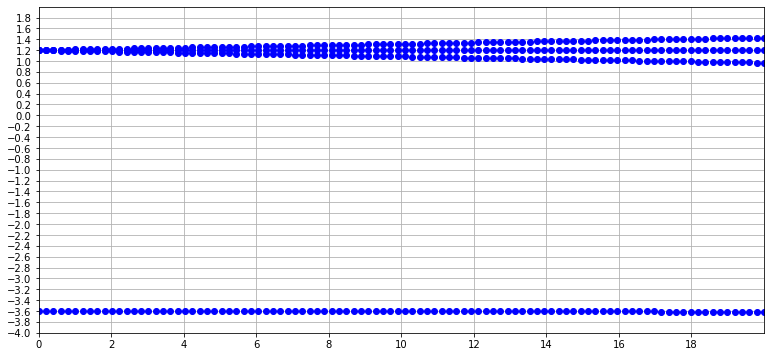

In [44]:
fig, ax = plt.subplots(1,1,figsize=(13,6))
zzz = np.linspace(0,20,100)

Zeeman_vector = np.vectorize(Zeeman_function)

for zss in zzz:
    res = Zeeman_function(zss)
    for ii in range(len(res)):
        ax.plot(zss,res[ii]*Gamma,"bo")

ax.set_xlim(0,20)
ax.set_ylim(-4,2)
ax.set_xticks(np.arange(0,20,2))
ax.set_yticks(np.arange(-4,2,0.2))
ax.grid()

Saturation intensity can be derived by below equation,
$$
\begin{equation}
I_{sat} = \frac{\pi h c} {3 \lambda^3 \tau}
\end{equation}
$$

remeber that above variables can be changed,
$$
\begin{equation}
\tau = \frac{1}{\Gamma} \\
\lambda = \frac{2 \pi c}{\Omega}
\end{equation}
$$

Gaussian beam intensity is,
$$
\begin{equation}
I = \frac{2P}{\pi w_b^2} \mathrm{exp}\left(-\frac{2r^2}{w_b^2}\right)
\end{equation}
$$
Since we use G/mm for magnetic field gradient, also $w_b$ in $\mathrm{exp}\left(-\frac{2r^2}{w_b^2}\right)$ should be mm units. So I put 12 in parameter wb.

In [3]:
omega = 2*np.pi*(cts.c/606e-9) #Transition frequency
Isat = cts.hbar*omega**3*(2*np.pi*Gamma*1e6)/(12*np.pi*cts.c**2)

# Make the magnetic field (2 G/mm):
magField = pylcp.quadrupoleMagneticField(2000*x0)

def six_beam_CaF_MOT(s, det):
    laserBeams = pylcp.laserBeams()
    for ii, Eg_i in enumerate(E_X):
        if ii<3:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=s, delta=(E_A[-1] - Eg_i)+det, pol=+1,wb=0.012/x0,
                beam_type=pylcp.gaussianBeam
                )
        else:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=s, delta=(E_A[-1] - Eg_i)+det, pol=-1,wb=0.012/x0,
                beam_type=pylcp.gaussianBeam
                )

    return laserBeams

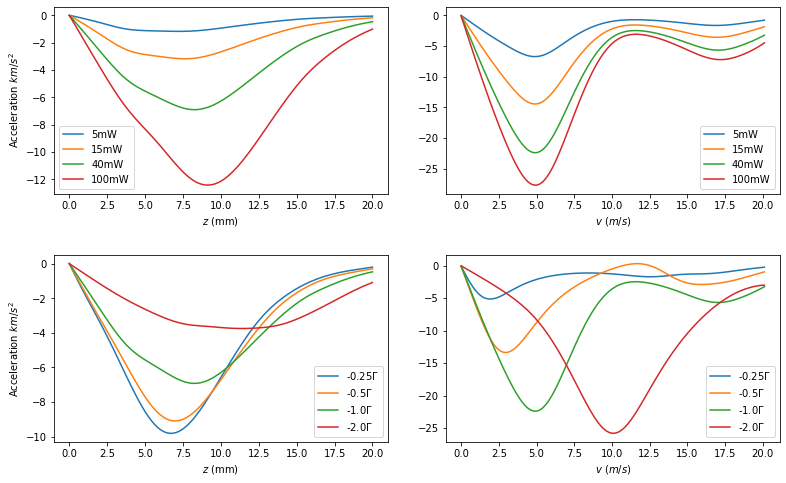

In [4]:
# The detunings used in the PRAs:
dets = np.array([-0.25, -0.5, -1, -2])
P = np.array([0.005, 0.015, 0.040, 0.1])
intensities = 2.*P/(np.pi*0.012**2)/Isat
# Make the axis:
z = np.linspace(0, 20e-3/x0, 101)
v = np.linspace(0., 4., 101)

# Start the figure:
fig, ax = plt.subplots(2, 2, figsize=(13, 8), num="Forces in CaF MOT")
for ii, intensity in enumerate(intensities):
    laserBeams = six_beam_CaF_MOT(intensity, dets[2])
    trap = pylcp.rateeq(laserBeams, magField, hamiltonian)
    trap.generate_force_profile(
        [np.zeros(z.shape), np.zeros(z.shape), z],
        [np.zeros(z.shape), np.zeros(z.shape), 1e-9*np.ones(z.shape)],
        name='Fz')
    trap.generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), 1e-9*np.ones(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='Fv')
    ax[0, 0].plot(z*x0*1000, trap.profile['Fz'].F[2]/mass*a0*1e-3, color='C{0:d}'.format(ii),label = f'{int(1000*P[ii])}mW')
    ax[0, 1].plot(v*v0, trap.profile['Fv'].F[2]/mass*a0*1e-3, color='C{0:d}'.format(ii),label = f'{int(1000*P[ii])}mW')

for ii, det_i in enumerate(dets):
    laserBeams = six_beam_CaF_MOT(intensities[2], det_i)
    trap = pylcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)
    trap.generate_force_profile(
        [np.zeros(z.shape), np.zeros(z.shape), z],
        [np.zeros(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
        name='Fz')
    trap.generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), 1e-9*np.ones(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='Fv')
    ax[1, 0].plot(z*x0*1000,trap.profile['Fz'].F[2]/mass*a0*1e-3, color='C{0:d}'.format(ii),label = f'{det_i}$\Gamma$')
    ax[1, 1].plot(v*v0,trap.profile['Fv'].F[2]/mass*a0*1e-3, color='C{0:d}'.format(ii),label = f'{det_i}$\Gamma$')

ax[0, 0].set_ylabel('Acceleration $km/s^2$')
ax[1, 0].set_ylabel('Acceleration $km/s^2$')

for ax_i in ax[:, 0]:
    ax_i.set_xlabel('$z$ (mm)')
    ax_i.legend()
for ax_i in ax[:, 1]:
    ax_i.set_xlabel('$v\ (m/s)$')
    ax_i.legend()
fig.subplots_adjust(hspace=0.33, wspace=0.175)
fig.savefig('D:/migration/picture/0520/rebuild_tarbutt.png')

In [5]:
delta0 = dets[2]
int0 = intensities[2]
dz = 0.0005/x0
dv = 0.5
zz = np.linspace(-0.02/x0,0.02/x0+dz,1000)
vv = np.linspace(-10,10+dv,100)
Z,V = np.meshgrid(zz,vv)

laserBeams = six_beam_CaF_MOT(int0,delta0)
magField = pylcp.quadrupoleMagneticField(2000*x0)
rateeq = pylcp.rateeq(laserBeams,magField,hamiltonian,include_mag_forces=False)

In [6]:
rateeq.generate_force_profile([np.zeros(Z.shape),np.zeros(Z.shape),Z],[np.zeros(V.shape),np.zeros(V.shape),V],name='F',progress_bar=1)

Completed in 2:01.                                                  


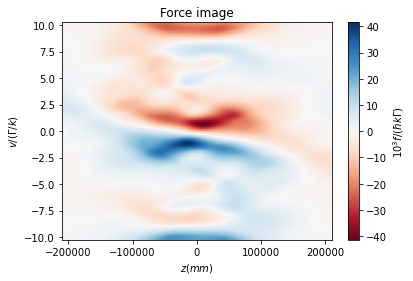

In [7]:
fig, ax = plt.subplots(1, 1)
plt.imshow(1e3*rateeq.profile['F'].F[2], origin='lower',
           extent=(np.amin(zz)-dz/2, np.amax(zz)-dz/2,
                   np.amin(vv)-dv/2, np.amax(vv)-dv/2),
           aspect='auto',cmap='RdBu')
cb1 = plt.colorbar()
cb1.set_label('$10^3f/(\hbar k \Gamma)$')
ax.set_xlabel('$z (mm)$')
ax.set_ylabel('$v/(\Gamma/k)$')
ax.set_title('Force image')
fig.subplots_adjust(left=0.12,right=0.9)

# fig.savefig('20210415_1.png')

In [8]:
def captured_condition(t, y, threshold=5e-2):
    if(y[-4]<threshold and abs(y[-1])<5e-4/x0):
        val = -1.
    else:
        val = 1.

    return val

def lost_condition(t, y, threshold=1e-5):
    if y[-1]>20e-3/x0 or y[-1]<-20e-3/x0:
        val = -1.
    else:
        val = 1.

    return val

captured_condition.terminal=True
lost_condition.terminal=True

In [9]:
v0s = np.arange(1.,10.0,1.)
t_eval = np.linspace(0.,2000000.,2000001)
sols_rate = list()

for v0a in v0s:
    rateeq.set_initial_position_and_velocity(np.array([0.,0.,-0.02/x0]),np.array([0.,0.,v0a]))
    rateeq.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))
    
    rateeq.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events = [captured_condition,lost_condition],progress_bar = 1,method='LSODA')
    sols_rate.append(rateeq.sol)

Completed in 5.95 s.                                                   
Completed in 5.41 s.                                                   
Completed in 5.61 s.                                                   
Completed in 4.78 s.                                                   
Completed in 5.41 s.                                                   
Completed in 6.60 s.                                                   
Completed in 6.55 s.                                                   
Completed in 9.77 s.                                                   
Completed in 9.01 s.                                                   


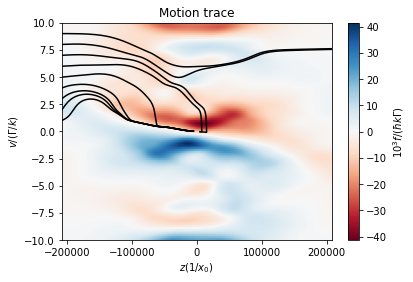

In [10]:
fig, ax = plt.subplots(1, 1)
plt.imshow(1e3*rateeq.profile['F'].F[2], origin='lower',
           extent=(np.amin(zz)-dz/2, np.amax(zz)-dz/2,
                   np.amin(vv)-dv/2, np.amax(vv)-dv/2),
           aspect='auto',cmap="RdBu")
cb1 = plt.colorbar()
cb1.set_label('$10^3f/(\hbar k \Gamma)$')
ax.set_xlabel('$z(1/x_0)$')
ax.set_ylabel('$v/(\Gamma/k)$')
ax.set_title('Motion trace')
ax.set_xlim(-0.02/x0,0.02/x0)
ax.set_ylim(-10,10)
fig.subplots_adjust(left=0.12,right=0.9)

for sol in sols_rate:
    ax.plot(sol.r[2],sol.v[2], 'k-')
    
# fig.savefig("200 mW)

In [11]:
for sol in sols_rate:
    if len(sol.t_events[0])==1:
        print('completely trapped')
    elif len(sol.t_events[1])==1:
        print('lost')
    else:
        print('i don`t know')

completely trapped
completely trapped
completely trapped
completely trapped
completely trapped
completely trapped
completely trapped
lost
lost


In [86]:
sol = sols_rate[4]

sol.r[2]

array([-2.07365852e+05, -2.07360852e+05, -2.07355853e+05, ...,
       -8.89334271e+00, -8.89330563e+00, -8.89326856e+00])

In [11]:
rateeq = pylcp.rateeq(laserBeams,magField,hamiltonian,include_mag_forces=False)
rateeq.generate_force_profile([Z,np.zeros(Z.shape),np.zeros(Z.shape)],[V,np.zeros(V.shape),np.zeros(V.shape)],name='Fx',progress_bar=1)
rateeq.generate_force_profile([np.zeros(Z.shape),Z,np.zeros(Z.shape)],[np.zeros(V.shape),V,np.zeros(V.shape)],name='Fy',progress_bar=1)

Completed in 15.42 s.                                               
Completed in 15.44 s.                                               


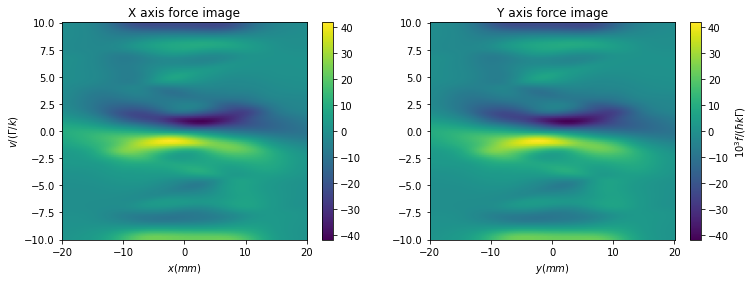

In [12]:
fig, ax = plt.subplots(1, 2,figsize=(12,4))

imx = ax[0].imshow(1e3*rateeq.profile['Fx'].F[0], origin='lower',
           extent=(np.amin(zz)-dz/2, np.amax(zz)-dz/2,
                   np.amin(vv)-dv/2, np.amax(vv)-dv/2),
           aspect='auto')
imy = ax[1].imshow(1e3*rateeq.profile['Fy'].F[1], origin='lower',
           extent=(np.amin(zz)-dz/2, np.amax(zz)-dz/2,
                   np.amin(vv)-dv/2, np.amax(vv)-dv/2),
           aspect='auto')
cbx = plt.colorbar(imx,ax = ax[0])
cby = plt.colorbar(imy,ax = ax[1])

cby.set_label('$10^3f/(\hbar k \Gamma)$')

ax[0].set_xlabel('$x (mm)$')
ax[0].set_ylabel('$v/(\Gamma/k)$')
ax[0].set_title('X axis force image')
ax[1].set_xlabel('$y (mm)$')
ax[1].set_title('Y axis force image')
fig.subplots_adjust(left=0.12,right=0.9)

fig.savefig('20210416_5.png')

In [13]:
def captured_condition(t, y, threshold=1e-2):
    if(y[-6]<threshold and abs(y[-3])<1e-3 and y[-5]<threshold and abs(y[-2])<1e-3):
        val = -1.
    else:
        val = 1.

    return val

def lost_condition(t, y, threshold=1e-5):
    if y[-3]>20 or y[-2]>50:
        val = -1.
    else:
        val = 1.

    return val

captured_condition.terminal=True
lost_condition.terminal = True

In [14]:
v0s = np.arange(1.,10.0,0.5)
t_eval = np.linspace(0.,200.,501)
sols_rate = list()

for v0a in v0s:
    rateeq.set_initial_position_and_velocity(np.array([-20.,-20.,0.]),np.array([v0a,v0a,0]))
    rateeq.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))
    
    rateeq.evolve_motion([0.,500.],t_eval=t_eval,max_step = 0.1,events = [captured_condition,lost_condition],progress_bar = 1)
    sols_rate.append(rateeq.sol)

Completed in 4.37 s.                                               
Completed in 2.92 s.                                               
Completed in 2.14 s.                                               
Completed in 1.81 s.                                               
Completed in 1.48 s.                                               
Completed in 1.28 s.                                               
Completed in 1.08 s.                                               
Completed in 0.94 s.                                               
Completed in 0.87 s.                                               
Completed in 0.77 s.                                               
Completed in 0.72 s.                                               
Completed in 0.69 s.                                               
Completed in 0.65 s.                                               
Completed in 0.62 s.                                               
Completed in 0.59 s.                            

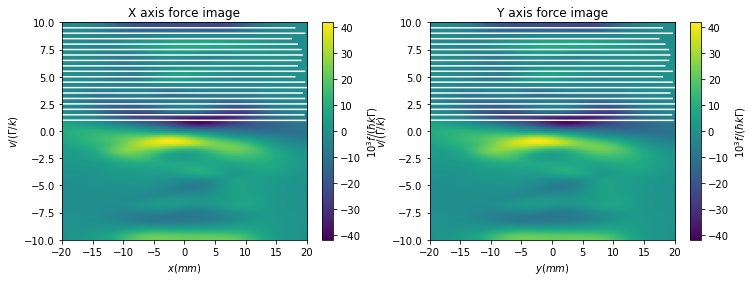

In [15]:
fig, ax = plt.subplots(1, 2,figsize=(12,4))

imx = ax[0].imshow(1e3*rateeq.profile['Fx'].F[0], origin='lower',
           extent=(np.amin(zz)-dz/2, np.amax(zz)-dz/2,
                   np.amin(vv)-dv/2, np.amax(vv)-dv/2),
           aspect='auto')
imy = ax[1].imshow(1e3*rateeq.profile['Fy'].F[1], origin='lower',
           extent=(np.amin(zz)-dz/2, np.amax(zz)-dz/2,
                   np.amin(vv)-dv/2, np.amax(vv)-dv/2),
           aspect='auto')
cbx = plt.colorbar(imx,ax = ax[0])
cby = plt.colorbar(imy,ax = ax[1])

cbx.set_label('$10^3f/(\hbar k \Gamma)$')
cby.set_label('$10^3f/(\hbar k \Gamma)$')

ax[0].set_xlabel('$x (mm)$')
ax[0].set_ylabel('$v/(\Gamma/k)$')
ax[0].set_title('X axis force image')
ax[0].set_xlim(-20,20)
ax[0].set_ylim(-10,10)
ax[1].set_xlabel('$y (mm)$')
ax[1].set_ylabel('$v/(\Gamma/k)$')
ax[1].set_title('Y axis force image')
ax[1].set_xlim(-20,20)
ax[1].set_ylim(-10,10)
fig.subplots_adjust(left=0.12,right=0.9)

for sol in sols_rate:
    ax[0].plot(sol.r[0],sol.v[0],'w-')
    ax[1].plot(sol.r[1],sol.v[1],'w-')

fig.savefig('20210423_4.png')

In [16]:
for sol in sols_rate:
    if len(sol.t_events[0])==1:
        print('completely trapped')
    elif len(sol.t_events[1])==1:
        print('lost')
    else:
        print('i don`t know')

lost
lost
lost
lost
lost
lost
lost
lost
lost
lost
lost
lost
lost
lost
lost
lost
lost
lost


In [17]:
# def is_trapped(v0,z0,eqn, captured_condition, lost_condition, tmax=1000, max_step=0.1, **kwargs):
#     eqn.set_initial_position_and_velocity(np.array([0.,0.,z0]),np.array([0.,0.,v0]))
#     if isinstance(eqn,pylcp.rateeq):
#         eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))
    
#     eqn.evolve_motion([0.,tmax],events = [captured_condition,lost_condition],max_step = max_step)
    
#     if len(eqn.sol.t_events[0]) == 1:
#         return 1
#     else:
#         return -1

In [18]:
# from scipy.optimize import root_scalar

# vc = root_scalar(is_trapped,bracket=[4.,5.],args = (-20,rateeq,captured_condition,lost_condition,300,0.1),method = 'brentq')

# vc

In [19]:
# vc.root*v0